#ECS7020P Mini-Project Basic submission


#1. Author
###Student Name: Satyam Sharma

###Student ID: 220760793

#2. Problem formulation
Using the MLEnd London Sounds dataset, build a machine learning pipeline that takes as an input an audio segment and predicts whether the audio segment has been recorded indoors or outdoors.



#3. Machine Learning Pipeline

The various stages are - 

A. Loading the dataset - Loading the .wav files from the link.

B. Intermediate Stages - 
   1. Feature Extraction -The .wav files were read and multiple features like  MFCC, Spectral Centroid, Spectral Bandwidth, Spectral Contrast and Chromagram for each note was extracted.
   2. Training Analysis - The training accuracy of the model for each test was analyzed using the cross validation score. The confusion matrix method has been used to calculate the Precision, Recall and Accuracy for each of the class and analyse further the training and validation accuracy.
   3. Validation Analysis - The validation accuracy of the model is calculated. The method of confusion matrix has been used to calculate the Precision, Recall and Accuracy for each of the class for the validation.

C. Based on the values, conclusion is made. 


Linking the Google Drive and importing the libraries

In [1]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

drive.mount('/content/drive')

import seaborn as sns
import scipy
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier



Mounted at /content/drive


Reading the Audio files dataset from the dataset

In [2]:
def download_url(url, save_path):
    with urllib.request.urlopen(url) as dl_file:
        with open(save_path, 'wb') as out_file:
            out_file.write(dl_file.read())

In [3]:
path = '/content/drive/MyDrive/Data/MLEndLS'
os.listdir(path)

['MLEndLS.csv', 'MLEndLS_Sample.csv', 'sample', 'Dataset', 'MLEndLS.xlsx']

In [4]:
sample_path = '/content/drive/MyDrive/Data/MLEndLS/Dataset/MLEndLS/*.wav'
files = glob.glob(sample_path)
len(files)

2494

In [5]:
MLENDLS_df = pd.read_excel('/content/drive/MyDrive/Data/MLEndLS/MLEndLS.xlsx').set_index('file_id')

In [6]:
MLENDLS_df.head(10)

,area,spot,in_out,Participant
file_id,,,,
0174.wav,kensington,albert,outdoor,S1
0222.wav,kensington,albert,outdoor,S107
0338.wav,kensington,albert,outdoor,S169
0374.wav,kensington,albert,outdoor,S84
0542.wav,kensington,albert,outdoor,S99
0615.wav,kensington,albert,outdoor,S32
0747.wav,kensington,albert,outdoor,S82
0765.wav,kensington,albert,outdoor,S103
0821.wav,kensington,albert,outdoor,S153


#4. Transformation Stage
Feature Extraction is done on this dataset. We use feature extraction to transform our data into numerical features and at the same time the original value is preserved.  
We define a function getPitch that returns the pitch of the Pitch of the audio file and getXy function extracts the features.

In [7]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [8]:
def getXy(files,labels_file, scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    file_name = file.split('/')[-1]
    yi = labels_file.loc[fileID]['in_out']=='indoor'

    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)

    #Extra Features
    mfccs = np.mean(librosa.feature.mfcc(x, sr=fs))
    chc=np.mean(librosa.feature.chroma_cqt(y=x,sr=fs))
    chs=np.mean(librosa.feature.chroma_stft(y=x,sr=fs))
    spc=np.mean(librosa.feature.spectral_centroid(y=x,sr=fs))
    spb=np.mean(librosa.feature.spectral_bandwidth(y=x,sr=fs))
    spcon=np.mean(librosa.feature.spectral_contrast(y=x,sr=fs))

    xi = [power,pitch_mean,pitch_std,voiced_fr,mfccs,chc,chs,spc,spb,spcon]
    X.append(xi)
    y.append(yi)

  return np.array(X),np.array(y)

Getting features and labels from the 2494 audio files and saving the values as well for later use.

In [12]:
X,y = getXy(files, labels_file=MLENDLS_df, scale_audio=True, onlySingleDigit=True)

 23%|██▎       | 574/2494 [23:49<1:13:28,  2.30s/it]/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=889
  warnings.warn(
100%|██████████| 2494/2494 [1:42:09<00:00,  2.46s/it]


In [13]:
#Saving the outputs incase we need it later
np.save('X.npy',X)
np.save('y.npy',y)

In [14]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
print('The labels vector is', y)

The shape of X is (2494, 10)
The shape of y is (2494,)
The labels vector is [False  True  True ... False  True False]


#5. Modeling
Grid Search is used to find the best parameters of each of the following models :

1. KNeighbour Classifier 
2. Random Forest Classifier
3. Extra Trees Classifier

#6. Methodology
The methodology is :

1. train_test_split: Data is split into 70% training data and 30% validation data.
2. Standard Scaler transformation is used to normalised the feature.
3. Feature selection and Repeated Stratified K Fold used
3. GridSearchCV - Grid Search Cross validation is used to find the optimal  values of the parameters. The param_grid is set with various range of parameter to select the best parameter to build the model.
4. Confusion Matrix is used to analyse the Precision, Recall and Accuracy for each of the classes during both the training and the validation phase.

#7. Dataset
1. The feature set is normalized since the data has varying scales and we need the data to be similar across all records.

2. After that, visualisations are done to determine the relationship between the features and the area.

3. Then the dataset is split using train-test-split() and 3 models are made.

In [15]:
features = pd.DataFrame(data=X, columns=['power','pitch_mean','pitch_std','voiced_fr','mfccs','chc','chs','spc','spb','spcon'])
features.head(10)

,power,pitch_mean,pitch_std,voiced_fr,mfccs,chc,chs,spc,spb,spcon
0,0.034535,0.000000,0.000000,0.000000,5.132097,0.591213,0.698601,1163.192364,2054.227214,16.476363
1,0.003815,124.758603,17.757853,0.078125,-11.077273,0.641995,0.469032,2760.106808,2022.645955,18.664418
2,0.013582,191.264966,21.315473,0.056291,0.650184,0.603029,0.540409,1657.519943,2451.251508,18.713161
3,0.008002,124.366324,37.368706,0.138736,-0.072637,0.485446,0.648142,940.104621,1674.565920,18.190393
4,0.016052,126.443580,9.911017,0.056782,-8.298968,0.668621,0.579022,3765.455881,3846.840545,18.536778
5,0.008356,236.657708,48.055864,0.100877,-1.126567,0.692991,0.590075,1905.874886,2309.638826,16.539609
6,0.003179,0.000000,0.000000,0.000000,-1.772250,0.726994,0.663131,2255.824113,2812.387315,17.265578
7,0.006184,162.432598,14.204691,0.091057,-1.387670,0.608256,0.569720,1449.174939,1635.756249,17.979348
8,0.006024,195.189920,22.814062,0.042846,-2.394723,0.694390,0.540099,1393.507133,1943.787195,17.162055
9,0.002021,133.218089,5.272707,0.036364,-10.160516,0.722867,0.585452,4002.896798,4268.099429,14.070719


In [16]:
scaler = StandardScaler() 
X = scaler.fit_transform(X)
Normalized_features = pd.DataFrame(data=X, columns=['power','pitch_mean','pitch_std','voiced_fr','mfccs','chc','chs','spc','spb','spcon'])
Normalized_features['class'] = y
enc = LabelEncoder() 
Normalized_features["Target"] = enc.fit_transform(Normalized_features["class"]) ## applying Label Encoder to changes the song name to numerical value.
Normalized_features['fileId'] = [file.split('/')[-1] for file in files if file.split('/')[-1] in MLENDLS_df.index]
Normalized_features.to_csv('MLENDLS_df_features.csv')


In [17]:
display(Normalized_features.head(10))

,power,pitch_mean,pitch_std,voiced_fr,mfccs,chc,chs,spc,spb,spcon,class,Target,fileId
0,2.079288,-1.962173,-0.985459,-1.070786,1.827065,-0.594447,1.886811,-1.038655,-0.688221,-0.950544,False,0,1497.wav
1,-0.953681,-0.357939,-0.169451,-0.086801,-2.748572,0.151880,-1.111485,1.211449,-0.732524,0.655769,True,1,1498.wav
2,0.010641,0.497246,-0.005971,-0.361795,0.561895,-0.420787,-0.179269,-0.342132,-0.131264,0.691553,True,1,1499.wav
3,-0.540273,-0.362984,0.731707,0.676599,0.357855,-2.148861,1.227786,-1.352993,-1.220822,0.307774,False,0,1500.wav
4,0.254435,-0.336273,-0.530028,-0.355612,-1.964302,0.543185,0.325046,2.628018,1.826511,0.562065,False,0,1501.wav
5,-0.505357,1.080938,1.222803,0.199764,0.060348,0.901342,0.469394,0.007808,-0.329922,-0.904113,False,0,1502.wav
6,-1.016517,-1.962173,-0.985459,-1.070786,-0.121918,1.401067,1.423549,0.500898,0.375349,-0.371159,False,0,1503.wav
7,-0.719811,0.126499,-0.332725,0.076077,-0.013357,-0.343976,0.203549,-0.635697,-1.275265,0.152840,True,1,1504.wav
8,-0.735585,0.547716,0.062892,-0.531145,-0.297631,0.921899,-0.183309,-0.714134,-0.843150,-0.447158,True,1,1505.wav
9,-1.130819,-0.249161,-0.743168,-0.612785,-2.489786,1.340414,0.409019,2.962580,2.417466,-2.716595,True,1,1506.wav


Visualisations done to determine the relationship between the features and the area.
1. Using Distance Matrix - the visualisation is not very useful for the dataset.
2. Using Spearman's Correlation Matrix - The redundant column can be dropped through this method. 
Afterwards, data cleaning is done and we drop 'Spb' as it is a redundant feature.

In [18]:
y_main = Normalized_features['Target']
X_main = Normalized_features[['power','pitch_mean','pitch_std','voiced_fr','mfccs','chc','chs','spc','spb','spcon'
           ]].to_numpy()

In [19]:
df_analysis_all = Normalized_features.drop(['class','fileId','Target'], axis=1)

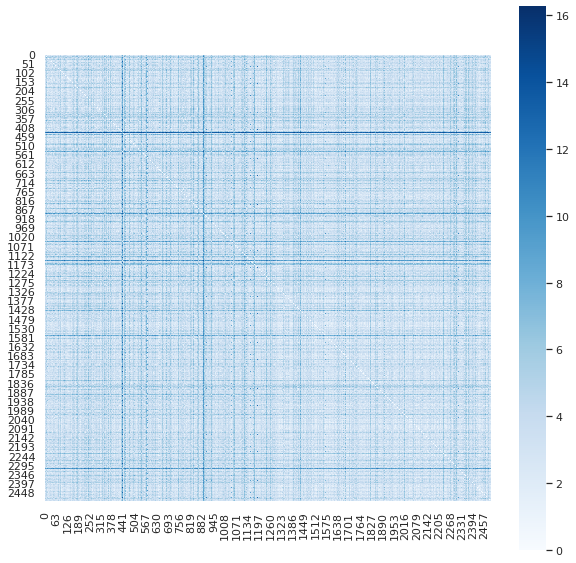

In [20]:
Features_sorted = Normalized_features.sort_values(by='class', ascending=True)

X1 = Features_sorted.drop(['fileId','class','Target'], axis=1).to_numpy()
scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
dist = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(X1))
sns.set(rc={'figure.figsize':(10,10)})
sns.heatmap(dist, square=True, cmap='Blues')
plt.show()

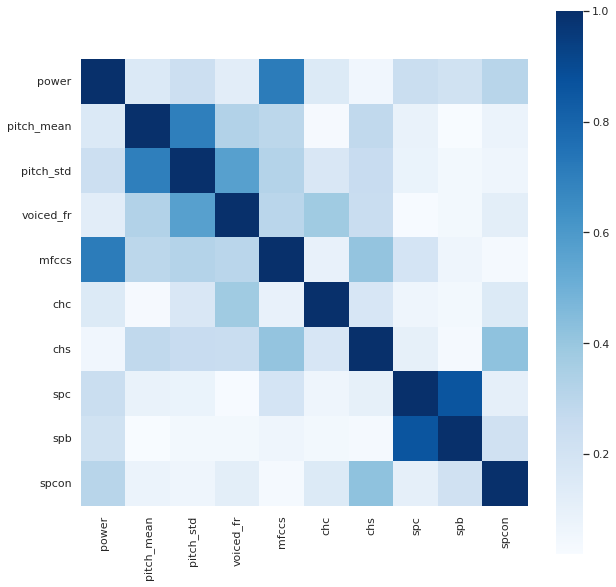

Column that can be dropped: ['spb']


<ipython-input-21-50a56aa74d84>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  highValue = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k = 1).astype(np.bool))


In [21]:
X1 = Normalized_features.drop(['fileId','class','Target'], axis=1)
corrMatrix = X1.corr(method = "spearman").abs()

#Generating heatmap of Spearman’s correlation matrix 
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrMatrix, cmap= "Blues", square=True, ax = ax)
plt.show()

#Selecting higher Value from the matrix
highValue = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k = 1).astype(np.bool))
to_drop = [column for column in highValue.columns if any(highValue[column] > 0.8)]
print('Column that can be dropped:',to_drop)
#Dropping features
X_main = X1.drop(to_drop, axis = 1)

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X_main,y_main,test_size=0.3,random_state=21)
X_train.shape, X_val.shape, y_train.shape, y_val.shape 

((1745, 9), (749, 9), (1745,), (749,))

In [23]:
X_train.shape

(1745, 9)

In [24]:
def predictScoreAndPlot(model, X, y, stage):
  y_pred = model.predict(X)

  precision, recall, fscore, _ = precision_recall_fscore_support(y, y_pred)

  print('\nPrecision for each class: {0}'.format(precision))
  print('Recall for each class: {0}'.format(recall))
  print('Accuracy for each class: {0}'.format(fscore))

  confusionMatrix = pd.DataFrame.from_records(confusion_matrix(y, y_pred))
  print('Confusion matrix for Data:')
  display(confusionMatrix)
  print('\n',stage,' Accuracy: {0}'.format(model.score(X, y)))

In [25]:
selection = SelectKBest()
scaler = StandardScaler()
pca = PCA(n_components=2)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=21)

parameter = {}
parameter.update({"knn" : dict(features__k=[1,3,5,7],knn__n_neighbors=[50, 75, 100])})
parameter.update({"rfc" : dict(features__k=[1,3,5,7],rfc__n_estimators=[4,8])})
parameter.update({"etc" : dict(features__k=[1,3,5,7],etc__n_estimators= [10,20])})
     

In [26]:
#Training the KNN Model
knn = KNeighborsClassifier()
pipeline = Pipeline([("scalar", scaler),("features", selection), ("knn", knn)])
param_grid = parameter.get("knn")

knnModel = GridSearchCV(pipeline, param_grid = param_grid, cv=cv)
knnModel.fit(X_train, y_train)
     

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=21),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('features', SelectKBest()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'features__k': [1, 3, 5, 7],
                         'knn__n_neighbors': [50, 75, 100]})

In [27]:
#Training performance 
print('Grid Search Best parameter selected:',knnModel.best_estimator_)
predictScoreAndPlot(knnModel, X_train, y_train,'Training')
     

Grid Search Best parameter selected: Pipeline(steps=[('scalar', StandardScaler()), ('features', SelectKBest(k=5)),
                ('knn', KNeighborsClassifier(n_neighbors=50))])

Precision for each class: [0.75902212 0.67945824]
Recall for each class: [0.6965812  0.74412855]
Accuracy for each class: [0.7264624  0.71032448]
Confusion matrix for Data:


,0,1
0,652,284
1,207,602



 Training  Accuracy: 0.7186246418338109


In [28]:
#Training the RFC Model
rfc = RandomForestClassifier()
pipeline = Pipeline([("scalar", scaler),("features", selection), ("rfc", rfc)])
param_grid = parameter.get("rfc")

rfcModel = GridSearchCV(pipeline, param_grid = param_grid, cv=cv)
rfcModel.fit(X_train, y_train)
     

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=21),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('features', SelectKBest()),
                                       ('rfc', RandomForestClassifier())]),
             param_grid={'features__k': [1, 3, 5, 7],
                         'rfc__n_estimators': [4, 8]})

In [29]:
#Training performance 
print('Grid Search Best parameter selected:',rfcModel.best_estimator_)
predictScoreAndPlot(rfcModel, X_train, y_train, 'Training')
     

Grid Search Best parameter selected: Pipeline(steps=[('scalar', StandardScaler()), ('features', SelectKBest(k=7)),
                ('rfc', RandomForestClassifier(n_estimators=8))])

Precision for each class: [0.96369295 0.99103713]
Recall for each class: [0.99252137 0.95673671]
Accuracy for each class: [0.97789474 0.97358491]
Confusion matrix for Data:


,0,1
0,929,7
1,35,774



 Training  Accuracy: 0.9759312320916905


In [30]:
#Training the ETC Model
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier()
pipeline = Pipeline([("scalar", scaler),("features", selection), ("etc", etc)]) 
param_grid = parameter.get("etc")

etcModel = GridSearchCV(pipeline, param_grid=param_grid, cv=cv)
etcModel.fit(X_train, y_train)
     

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=21),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('features', SelectKBest()),
                                       ('etc', ExtraTreesClassifier())]),
             param_grid={'etc__n_estimators': [10, 20],
                         'features__k': [1, 3, 5, 7]})

In [31]:
#Training performance 
print('Grid Search Best parameter selected:',etcModel.best_estimator_)
predictScoreAndPlot(etcModel, X_train, y_train, 'Training')
     

Grid Search Best parameter selected: Pipeline(steps=[('scalar', StandardScaler()), ('features', SelectKBest(k=5)),
                ('etc', ExtraTreesClassifier(n_estimators=20))])

Precision for each class: [1. 1.]
Recall for each class: [1. 1.]
Accuracy for each class: [1. 1.]
Confusion matrix for Data:


,0,1
0,936,0
1,0,809



 Training  Accuracy: 1.0


#8. Results
1. Validation Result for the KNN Model
2. Validation Result for the RFC Model
3. Validation Result for the Extra Tree Classifier Model

The Validation accuracy is the maximum for the KNN Model (72.5%).

In [32]:
#Validation report for KNN Model
predictScoreAndPlot(knnModel, X_val, y_val, 'Validation')


Precision for each class: [0.75366569 0.70098039]
Recall for each class: [0.67810026 0.77297297]
Accuracy for each class: [0.71388889 0.73521851]
Confusion matrix for Data:


,0,1
0,257,122
1,84,286



 Validation  Accuracy: 0.7249666221628839


In [33]:
#Validation report for RFC Model
predictScoreAndPlot(rfcModel, X_val, y_val,'Validation')
     


Precision for each class: [0.65517241 0.70063694]
Recall for each class: [0.75197889 0.59459459]
Accuracy for each class: [0.7002457  0.64327485]
Confusion matrix for Data:


,0,1
0,285,94
1,150,220



 Validation  Accuracy: 0.6742323097463284


In [34]:
#Validation Report for Extra Tree Classifier Model
predictScoreAndPlot(etcModel, X_val, y_val,'Validation')


Precision for each class: [0.70126582 0.71186441]
Recall for each class: [0.73087071 0.68108108]
Accuracy for each class: [0.71576227 0.6961326 ]
Confusion matrix for Data:


,0,1
0,277,102
1,118,252



 Validation  Accuracy: 0.7062750333778371


#9. Conclusions
The validation accuracy that we obtained from the 3 models is pretty good and hence we have a reasonable model at prediction whether an audio recording is done 'indoors' or not. The KNN model performs the best with an accuracy of 72.5%.
